# Analyzing Uncertainty in an Integrated Hydrologic  Model Using Active Subspaces

##### Ryan Howard, CO School of Mines, <ryhoward@mines.edu>
##### Paul Constantine, CO School of Mines, <pconstan@mines.edu>

<br>

In this notebook, we'll be summarizing the active subspaces-based uncertainty quantification on an integrated hydrologic model, presented in [[1]][R1].

### Introduction

Weather and climate conditions are very dependent on energy fluxes into and out of the land surface. For example, evaporation and its eventual precipitation are dependent on latent heat fluxes (which redistribute water between land and the atmosphere) and sensible and ground heat fluxes (which determine the land surface and subsurface temperatures). It is difficult to directly measure such quantities, so hydrologic models have arisen to estimate these fluxes and their effects. These models can be complex, requiring 10 to 50 input parameters, and many of these parameters are difficult to measure accurately. This introduces uncertainty, and the effect of this uncertainty on model output is important to understand the model's efficacy.

### The Integrated Hydrologic Model

Integrated hydrologic models combine elements of groundwater and land surface models, accounting for water flow in saturated and unsaturated subsurface regions and variation in water table depth. These models should represent natural systems more realistically than the alternatives, but they have been historically less well studied. We'll be using the ParFlow-Common Land Model (PF-CLM) and studying 19 of its land surface parameters and how they relate to the heat fluxes. The PF-CLM is a set of PDEs and algebraic equations that can be numerically approximated to obtain estimates of latent, sensible, and ground heat fluxes. The 19 parameters we study are described in the table below.

Variable|Name|distribution (U(min, max) or LN(mu, sigma))
:-------|:---|:----
Maximum Dew on Canopy|dewmx|U(.05, .15)
Leaf area index (maximum)|lai|U(1, 4)
Leaf area index (minimum)|	lai0|	U(0.05, 3)
Stem area index|	sai|	U(0.5, 4)
Leaf and stem orientation index|	xl|	U(−0.3, 0.4)
Leaf dimension|	dleaf|	U(0, 0.16)
Leaf reflectance (visible light)|	rhol_vis|	U(0.06, 0.13)
Leaf reflectance (near infrared light)|	rhol_nir|	U(0.35, 0.55)
Stem reflectance (visible light)|	rhos_vis|	U(0.3, 0.4)
Stem reflectance (near infrared light)|	rhos_nir|	U(0.5, 0.6)
Leaf transmittance (visible light)|	taul_vis|	U(0.01, 0.09)
Leaf transmittance (near infrared light)|	taul_nir|	U(0.1, 0.45)
Stem transmittance (visible light)|	taus_vis|	U(0.15, 0.25)
Stem transmittance (near infrared light)|	taus_nir|	U(0.3, 0.4)
Field capacity|	fieldcap|	U(0.3, 1)
Wilting point|	wiltpt|	U(0.1, 0.3)
Aerodynamic roughness length (bare soil)|	z0m|	LN(−8.83, 1.47)
Aerodynamic roughness length (grass)|	z0m|	LN(−5.11, 0.52)
Soil color|	soilcol|	U(1, 8)
Water table depth (below surface)|	watertable|	U(−10, −1)

Two domains were simulated: a single column domain and a tilted-v domain, a primary difference being the absence (single column) or presence (tilted-v) of lateral water flow. Each domain was run with uniform cover of bare soil (which takes only the final 3 parameters) or grass, totaling 4 simulation classes, one for each combination of (single column or tilted-v) and (bare soil or grass). The simulations require several atmospheric inputs, for which meteorological data from the Little Washita watershed in Oklahoma was used, and subsurface parameters were set to nominal values since we are only concerned with sensitivity to surface parameters.

### Active Subspaces

We'll be using active subspaces to study the relationship between the PF-CLM's 19 parameters and our quantities of interest (latent, sensible, and ground heat). The active subspaces methodology identifies important directions in the input space, along which the output changes more than in the orthogonal directions (see [[2]][R2] and [3] for more details). The important directions are defined by the eigenvectors of a matrix computed from the gradient of the output with respect to the parameters. We don't have direct access to this gradient for the PF-CLM and using a finite difference approximation would be computationally infeasible (requiring 19 additional model evaluations per gradient sample), so we use the following algorithm to identify the _single_ most important direction in the input space: for $M$ sets of inputs $\{\mathbf x_i\}_{i=1}^M$ and corresponding outputs $\{f_i\}$, use least squares to find the coefficients, $\hat a_0$ and $\hat{\mathbf a}$, of the linear model $f_i = a_0 + \mathbf a^T\mathbf x_i$; the important direction in the input space is $\hat{\mathbf w} = {\hat{\mathbf a}}/{||\hat{\mathbf a}||}$. If we observe a tight univariate trend when plotting $f_i$ vs $\hat{\mathbf w}^T\mathbf x_i$, we can reasonably approximate $f(\mathbf x)\approx g(\hat{\mathbf w}^T\mathbf x)$, where $f$ represents the quantity of interest as a function of the inputs and $g$ is a function constructed from the pairs $(\hat{\mathbf w}^T\mathbf x_i,\ f_i)$.

### References:

[[1]][R1] Active subspaces for sensitivity analysis and dimension reduction of an integrated hydrologic model, _Computers & Geosciences_

[[2]][R2] Active Subspace Methods in Theory and Practice: Applications to Kriging Surfaces, _Siam Journal of Scientific Computing_

[3] Active Subspaces: Emerging Ideas for Dimension Reduction in Parameter Studies, ISBN: 978-1-611973-85-3, _The Society of Industrial and Applied Mathemeticians (SIAM)_

<br>

We'll now code up the analysis using the [Python Active-subspaces Utility Library](https://github.com/paulcon/active_subspaces). We'll only be presenting the single column domain; for the details of the tilted-v domain, see [[1]][R1]. We'll also be using updated model evaluations compared to [[1]][R1]; because of this, the figures presented will look slightly different than in the paper. The significant conclusions are the same.

[R1]: http://dx.doi.org/10.1016/j.cageo.2015.07.001
[R2]: http://dx.doi.org/10.1137/130916138

In [1]:
import active_subspaces as ac
import numpy as np
import matplotlib.pyplot as plt
import pandas as pn
%matplotlib inline

Read the data (inputs and outputs) from files and order the inputs as we want.

In [2]:
#Read input parameters
inputs_bare = pn.read_csv('SC_ScatterParameters_bare.txt', sep=' ')
inputs_grass = pn.read_csv('SC_ScatterParameters_grass.txt', sep=' ')

#Match ordering of the paper
ordering = ['dewmx', 'lai', 'lai0', 'sai', 'xl', 'dleaf', 'rhol_vis', 'rhol_nir',\
           'rhos_vis', 'rhos_nir', 'taul_vis', 'taul_nir', 'taus_vis', 'taus_nir',\
           'fieldcap', 'wiltpt', 'z0m', 'soilcol', 'watertable']
inputs_grass = inputs_grass[ordering]

ordering = ['z0m', 'soilcol', 'watertable']
inputs_bare = inputs_bare[ordering]

#Change dataFrames to matrices, use log(z0m) instead of z0m
X_bare = inputs_bare.as_matrix()[:,:]
X_grass = inputs_grass.as_matrix()[:,:]
X_bare[:,-3], X_grass[:,-3] = np.log(X_bare[:,-3]), np.log(X_grass[:,-3])

#lists of parameter labels
in_labels_bare = inputs_bare.keys()
in_labels_grass = inputs_grass.keys()

#Read outputs
outputs_bare = pn.read_csv('ScatterSummary_bare.txt', sep=' ', header=None).as_matrix()
outputs_grass = pn.read_csv('ScatterSummary_grass.txt', sep=' ', header=None).as_matrix()

#LH = latent heat, SH = sensible heat, GH = ground heat
LH_bare, LH_grass = outputs_bare[:,0], outputs_grass[:,0]
SH_bare, SH_grass = outputs_bare[:,1], outputs_grass[:,1]
GH_bare, GH_grass = outputs_bare[:,2], outputs_grass[:,2]
outputs_bare = [LH_bare, SH_bare, GH_bare]
outputs_grass = [LH_grass, SH_grass, GH_grass]

out_labels = ['Total Latent Heat', 'Total Sensible Heat', 'Total Ground Heat']

Normalize the uniform inputs to the interval $[-1, 1]$ and normalize the normal inputs (log(z0m)) to be $\frac{x - \mu}{\sigma}$.

In [3]:
#Upper and lower limits on uniform-bounded inputs
yl = np.array([.05, 1, .05, .5, -.3, 0, .06, .35, .3, .5, .01, .1, .15, .3, .3, .1, 1, -10])
yu = np.array([.15, 4, 3, 4, .4, .16, .13, .55, .4, .6, .09, .45, .25, .4, 1, .3, 8, -1])

#Normalize Uniform-bounded inputs
Y_bare = X_bare[:,1:]
Y_bare = ac.utils.misc.BoundedNormalizer(yl[-2:], yu[-2:]).normalize(Y_bare)
Y_grass = np.hstack((X_grass[:,:-3], X_grass[:,-2:]))
Y_grass = ac.utils.misc.BoundedNormalizer(yl, yu).normalize(Y_grass)

#Normalize Gaussian inputs, combine with normalized Uniform inputs
z0m_bare = ((X_bare[:,-3] + 8.83)/1.47).reshape(X_bare.shape[0], 1)
z0m_grass = ((X_grass[:,-3] + 5.11)/.52).reshape(X_grass.shape[0], 1)
XX_bare = np.hstack((z0m_bare, Y_bare))
XX_grass = np.hstack((Y_grass[:,:-2], z0m_grass, Y_grass[:,-2:]))

Each of the 6 combinations of (bare or grass) and one of (latent, sensible, or ground) get a subspace object. Compute the active subspace (the sstype=5 flag specifies to use the algorithm described above).

In [4]:
#instantiate subspace objects, compute OLS subspaces for each output for bare soil
ss_bare_LH = ac.subspaces.Subspaces()
ss_bare_SH = ac.subspaces.Subspaces()
ss_bare_GH = ac.subspaces.Subspaces()
ss_bare = [ss_bare_LH, ss_bare_SH, ss_bare_GH]
for i in range(3):
    ss_bare[i].compute(X=XX_bare, f=outputs_bare[i][:,None], nboot=500, sstype=5)

#Set up subspaces for grass-covered soil
ss_grass_LH = ac.subspaces.Subspaces()
ss_grass_SH = ac.subspaces.Subspaces()
ss_grass_GH = ac.subspaces.Subspaces()
ss_grass = [ss_grass_LH, ss_grass_SH, ss_grass_GH]
for i in range(3): 
    ss_grass[i].compute(X=XX_grass, f=outputs_grass[i][:,None], nboot=500, sstype=5)

Plot components of $\hat{\mathbf w}$ for grass-covered soil (blue) and bare soil (red) for each heat output. See also Figure 5 of [[1]][R1] (recall that we're using updated data, so the figures will look slightly different. Also, since normalized eigenvectors are unique up to a sign, some plots may appear vertically flipped compared to the paper).

[R1]: http://dx.doi.org/10.1016/j.cageo.2015.07.001

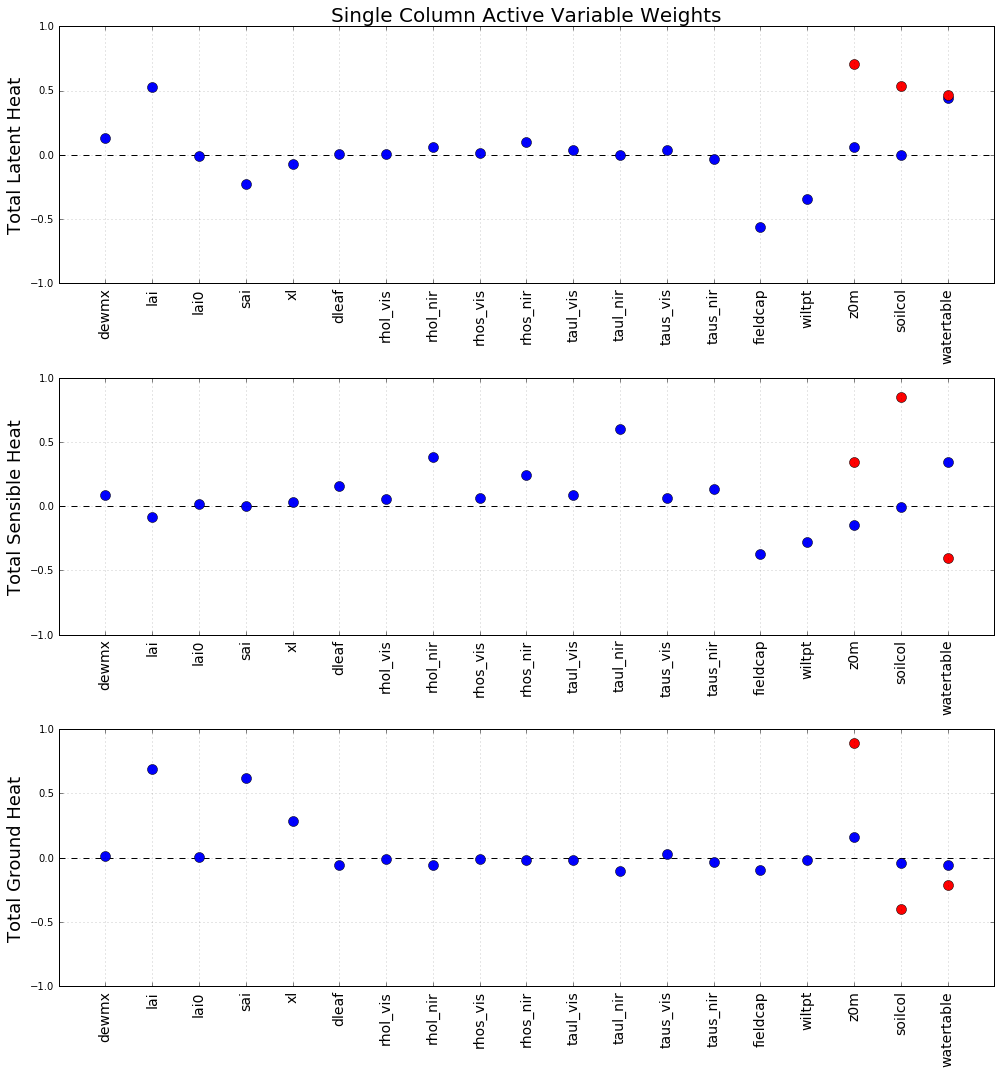

In [5]:
#Plot eigenvector components
fig = plt.figure(figsize=(14,15))
for i in range(3):
    ax = fig.add_subplot(3,1,i+1)
    if i == 0: ax.set_title('Single Column Active Variable Weights', fontsize=20)
    ax.set_ylim([-1,1]); ax.set_ylabel(out_labels[i], fontsize=18)
    ax.set_xlim([0,XX_grass.shape[1]+1]); ax.set_xticks(range(1,XX_grass.shape[1]+1))
    ax.grid(True, alpha=.4)
    ax.hlines(0, 0, 20, linestyles='dashed', colors='k')
    ax.set_xticklabels(in_labels_grass, rotation='vertical', fontsize=14)
    ax.plot(range(1,20), ss_grass[i].W1, 'bo', range(17,20), ss_bare[i].W1, 'ro', ms=10)
fig.tight_layout()

The magnitude of each component tells us how sensitive the output is to that variable; the output tends to change more with variables with large-magnitude components compared to those with small-magnitude components. For latent heat (for grass-covered soil), we can see that lai (leaf area index), fieldcap (field capacity), wiltpt (wilting point), and watertable (water table depth) strongly affect latent heat; all the other parameters have components close to 0, indicating little effect by them. Likewise, rhol_nir, taul_nir, fieldcap, wiltpt, and watertable strongly affect sensible heat, and lai, sai, and xl affect ground heat. We can see large weight on the three bare-soil parameters in all three cases, except watertable for ground heat. The most significant variables for bare soil are z0m (aerodynamic roughness length) for latent and ground heat and soilcol (soil color) for sensible heat.

<br>

Now we plot the quantities of interest vs the active variable ($\hat{\mathbf w}^T\mathbf x$) (blue dots) and a quadratic response surface (black line) with confidence limits (dark blue shading) and prediction limits (light blue shading). See also Figure 5 of [[1]][R1]. Again recall that since we're using updated data, these graphs will look different from the paper, and if an eigenvector is sign-flipped compared to the paper, the corresponding graph will be horizontally flipped.

[R1]: http://dx.doi.org/10.1016/j.cageo.2015.07.001

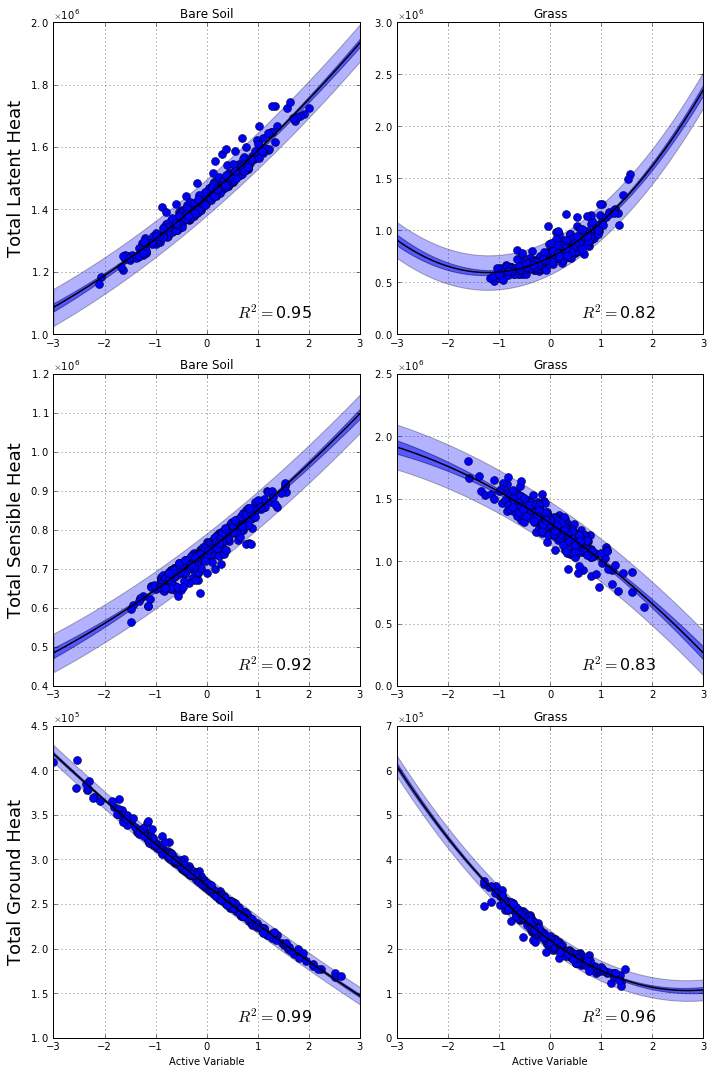

In [6]:
from matplotlib import ticker

#Response surface object
RS = ac.utils.response_surfaces.PolynomialApproximation()

#Confidence limits (prediction iff pred = 1.0) using +/- 2.33 std errors
def conflim(x, f, y, pred=0):
    M = len(y)
    sf = np.sqrt(sum((f - RS.predict(y)[0].reshape(f.shape))**2)/(M - 3))
    sy = sum((y - y.mean())**2)
    return [RS.predict(x)[0] - 2.33*sf*np.sqrt(pred + 1./M + (x - y.mean())**2/sy),
           RS.predict(x)[0] + 2.33*sf*np.sqrt(pred + 1./M + (x - y.mean())**2/sy)]

titles = ['Bare Soil', 'Grass']
subspaces = [ss_bare, ss_grass]
XX = [XX_bare, XX_grass]
f = [outputs_bare, outputs_grass]

#Plot output vs active variable with confidence and prediction limits
fig = plt.figure(figsize=(10,15))
for i in range(6):
    ax = fig.add_subplot(3,2,i+1)
    ax.set_title(titles[i%2])
    ax.set_xlim([-3,3])
    if i%2 == 0: ax.set_ylabel(out_labels[i/2], fontsize=18)
    ax.grid(True)
    if i/2 == 2: ax.set_xlabel('Active Variable')
    
    #plot data, prediction, confidence/prediction limits
    N = 500
    x = np.linspace(-3, 3, N)[:,None]
    y = XX[i%2].dot(subspaces[i%2][i/2].W1)
    RS.train(y, f[i%2][i/2][:,None])
    clims = conflim(x, f[i%2][i/2], y)
    plims = conflim(x, f[i%2][i/2], y, 1.0)
    ax.plot(y, f[i%2][i/2], 'bo', x, RS.predict(x)[0], 'k-', lw=1.5, ms=8)
    ax.fill_between(x.reshape(N,), clims[0].reshape(N,), clims[1].reshape(N,), alpha=.5)
    ax.fill_between(x.reshape(N,), plims[0].reshape(N,), plims[1].reshape(N,), alpha=.3)
    ax.text(.6, .05, r'$R^2 = $' + '{:.2f}'.format(RS.Rsqr),\
            transform=ax.transAxes, fontsize=16)
    
    #scientific notation on y axis
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-1, 1)) 
    ax.yaxis.set_major_formatter(formatter)
fig.tight_layout()

Some intuition of the physical system can help to explain some of our results. For example, there is a tighter trend in the case of ground heat compared to latent and sensible heats, and this could be caused by watertable being weighted lowly for ground compared to latent and sensible. Water table depth can heavily influence energy fluxes because conditions can change from dry to moist or vice-versa within a short time; these variations could introduce nonlinear behavior that we can't capture with linear models.

<br>

Summary plots and response surfaces can be used for several purposes. For example, suppose we fixed parameters at nominal values (see Table 2 of [[1]][R1]) and we were intersted in the effect of increasing or decreasing the leaf area index (lai) by 1. It is straightforward to find the active variable values associated with these cases and evaluate the response surface at these values for predictions of the effects, and this can be easily visualized because of the low-dimensional nature of the subspace. We can also use response surfaces for the inverse problem; we observe data, use the response surface to find the active variable value(s) that we expect to produce our observations, and invert the map from inputs to the active variable to find sets (ranges) of input values that would produce what we observe. We illustrate these examples below (see also Figure 8 of [[1]][R1]).

[R1]: http://dx.doi.org/10.1016/j.cageo.2015.07.001

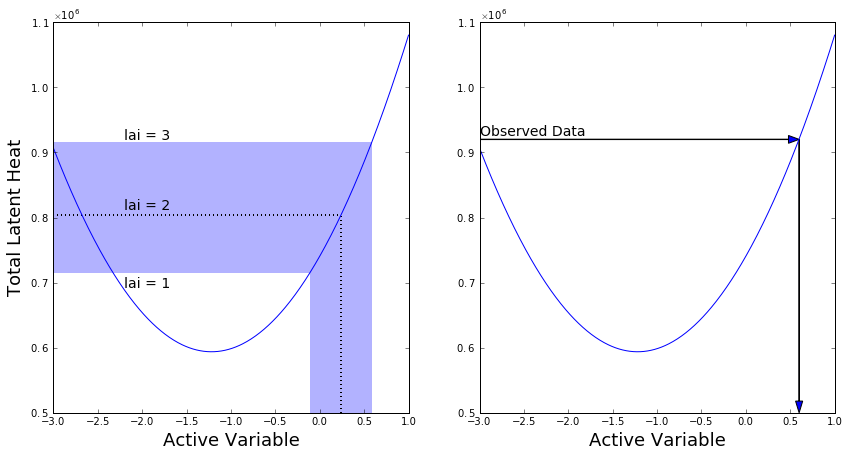

In [7]:
#Nominal input values
input_nominal = np.array([.1, 2, .5, 4, -.3, .04, .11, .58, .36, .58, .07,\
                          .25, .22, .38, 1, .1, np.log(.03), 2, -1])[None,:]

#normalize nominal inputs
Y_nom = np.hstack((input_nominal[:,:-3], input_nominal[:,-2:]))
Y_nom = ac.utils.misc.BoundedNormalizer(yl, yu).normalize(Y_nom)
z0m_nom = ((input_nominal[:,-3] + 5.11)/.52).reshape(input_nominal.shape[0], 1)
XX_nom = np.hstack((Y_nom[:,:-2], z0m_nom, Y_nom[:,-2:]))

#nominal active variable value
y_nom = XX_nom.dot(ss_grass_LH.W1)
#Train the response surface with grass LH data
RS.train(XX_grass.dot(ss_grass_LH.W1), LH_grass[:,None])
#Nominal output value
f_nom = RS.predict(y_nom)[0]

#values of active variable, predicted output for lai + 1
XX_laip1 = XX_nom.copy(); XX_laip1[0,1] = 2.*(3-1)/3.-1.; 
y_laip1 = XX_laip1.dot(ss_grass_LH.W1)
f_laip1 = RS.predict(y_laip1)[0]

#values of active variable, predicted output for lai - 1
XX_laim1 = XX_nom.copy(); XX_laim1[0,1] = 2.*(1-1)/3.-1.; 
y_laim1 = XX_laim1.dot(ss_grass_LH.W1)
f_laim1 = RS.predict(y_laim1)[0]

fig, axes = plt.subplots(1, 2, figsize=(14,7))

#The effects of perturbing lai by 1
x = np.linspace(-3, 1, 500)[:,None]
axes[0].plot(x, RS.predict(x)[0])
axes[0].hlines(f_nom, -3, y_nom, linestyles='dotted', linewidth=2)
axes[0].vlines(y_nom, .5e6, f_nom, linestyles='dotted', linewidth=2)
axes[0].fill_between(x[x <= y_laip1], f_laim1.squeeze(), f_laip1.squeeze(),\
                     alpha=.3, linewidth=0)
axes[0].fill_between(x[np.logical_and(x >= y_laim1, x <= y_laip1)], .5e6,\
                     f_laim1.squeeze(), alpha=.3, linewidth=0)
axes[0].set_ylabel(out_labels[0], fontsize=18)
axes[0].set_xlabel('Active Variable', fontsize=18)
axes[0].text(.2, .52, 'lai = 2', transform=axes[0].transAxes, fontsize=14)
axes[0].text(.2, .7, 'lai = 3', transform=axes[0].transAxes, fontsize=14)
axes[0].text(.2, .32, 'lai = 1', transform=axes[0].transAxes, fontsize=14)

#visualization of the inverse problem
axes[1].plot(x, RS.predict(x)[0])
axes[1].set_xlabel('Active Variable', fontsize=18)
axes[1].arrow(0, .7, .87, 0, transform=axes[1].transAxes)
axes[1].arrow(.9, .7, 0, -.67, transform=axes[1].transAxes)
axes[1].text(.0, .71, 'Observed Data', transform=axes[1].transAxes, fontsize=14)

#Scientific notation on y axes
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1, 1)) 
axes[0].yaxis.set_major_formatter(formatter); axes[1].yaxis.set_major_formatter(formatter)

The presence of an exploitable active subspace in this model serves as a proof-of-concept in the application of this methodology to hydrologic models. Active subspaces may be present in other hydrologic models for various domains, climate conditions, and sets of input parameters. The dimension reduction provided by these methods, especially for expensive, high-dimensional models, could aid in making accurate and timely predictions, optimizing output over the input space, or calibrating parameters, and if a sufficiently accurate approximation is found in the active subspace for a particular case, expensive simulation could be eschewed altogether in that case.